In [1]:
from pathlib import Path

import h5py
import pandas as pd
from openslide import OpenSlide
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import cv2
from torch.nn.functional import normalize
from PIL import Image
from histopreprocessing.features.foundation_models import load_model

from histopatseg.fewshot.protonet import ProtoNet, prototype_topk_vote
from histopatseg.fewshot.extract_patch_features import extract_patch_features_from_dataloader
from histopatseg.data.compute_embeddings_tcga_ut import load_hdf5


In [2]:
label_map = {"aca_bd": 0, "aca_md": 1, "aca_pd":2, "nor":3}

In [3]:
project_dir = Path(".").resolve().parent
print(f"Project Directory: {project_dir}")

Project Directory: /home/valentin/workspaces/histopatseg


In [4]:
embedding_file = project_dir / "data/processed/embeddings/LungHist700/lunghist700_20x_UNI2_embeddings.npz"
metadata  = pd.read_csv(project_dir / "data/processed/LungHist700_tiled/LungHist700_20x/metadata.csv").set_index("tile_id")
metadata.head()

,patient_id,superclass,subclass,resolution,image_id,class_name,label,original_filename,tile_path
tile_id,,,,,,,,,
aca_bd_20x_0_tile_0_0,5,aca,bd,20x,0,aca_bd,0,aca_bd_20x_0,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_20x_0_tile_0_1,5,aca,bd,20x,0,aca_bd,0,aca_bd_20x_0,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_20x_0_tile_0_2,5,aca,bd,20x,0,aca_bd,0,aca_bd_20x_0,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_20x_0_tile_0_3,5,aca,bd,20x,0,aca_bd,0,aca_bd_20x_0,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_20x_0_tile_0_4,5,aca,bd,20x,0,aca_bd,0,aca_bd_20x_0,data/processed/LungHist700_tiled/LungHist700_2...


In [5]:
# Load the embeddings
data = np.load(embedding_file)
embeddings = data["embeddings"]
tile_ids = data["tile_ids"]
embedding_dim = data["embedding_dim"]

# Print basic information
print(f"Loaded {len(embeddings)} embeddings with dimensionality {embeddings.shape[1]}")
print(f"Embedding dimension from model: {embedding_dim}")

Loaded 21216 embeddings with dimensionality 1536
Embedding dimension from model: 1536


In [6]:
embeddings_df = pd.DataFrame(
    {
        "tile_id": tile_ids,
        "embeddings": list(embeddings),  # Add embeddings as a column
    }
).set_index("tile_id")

In [7]:
df = pd.concat([embeddings_df, metadata], axis=1)

In [8]:
df_filtered = df[(df["superclass"] == "aca") | (df["superclass"] == "nor")]
num_classes = 4

In [9]:
df_filtered.head()

,embeddings,patient_id,superclass,subclass,resolution,image_id,class_name,label,original_filename,tile_path
tile_id,,,,,,,,,,
aca_md_20x_9_tile_7_3,"[-0.03690551, -0.085723646, 0.51837975, -0.330...",16,aca,md,20x,9,aca_md,1,aca_md_20x_9,data/processed/LungHist700_tiled/LungHist700_2...
nor_20x_69_tile_0_0,"[-0.055023268, -0.26404753, -0.37971297, -0.41...",42,nor,NaN,20x,69,nor,3,nor_20x_69,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_40x_64_tile_0_1,"[-0.3068757, -0.4340682, 0.05070163, -0.259684...",9,aca,bd,40x,64,aca_bd,0,aca_bd_40x_64,data/processed/LungHist700_tiled/LungHist700_2...
aca_md_20x_904_tile_5_4,"[-0.3510689, -0.558439, 0.2420596, -0.5120364,...",2,aca,md,20x,904,aca_md,1,aca_md_20x_904,data/processed/LungHist700_tiled/LungHist700_2...
aca_bd_20x_17_tile_7_4,"[0.105307765, -0.13721268, -0.8670957, -0.3939...",6,aca,bd,20x,17,aca_bd,0,aca_bd_20x_17,data/processed/LungHist700_tiled/LungHist700_2...


In [ ]:
# Extract embeddings and labels
embeddings_train = np.stack(df_filtered["embeddings"].values)
labels_train = df_filtered["class_name"].values
labels_train = np.array([label_map[label] for label in labels_train])


In [11]:
embeddings_train

array([[-0.03690551, -0.08572365,  0.51837975, ...,  0.18123378,
        -0.31948763, -0.14821334],
       [-0.05502327, -0.26404753, -0.37971297, ..., -0.00360388,
        -0.7765349 ,  0.64426076],
       [-0.3068757 , -0.4340682 ,  0.05070163, ...,  0.15288441,
         0.19777794,  0.29887396],
       ...,
       [-0.05263868, -0.9531991 , -0.5671515 , ...,  0.5075859 ,
        -0.57245636,  0.0526694 ],
       [-0.22541294,  0.21258265, -0.13743931, ...,  0.43672216,
         0.37118235,  0.8386634 ],
       [ 0.22746056, -0.01127153,  0.7195034 , ...,  0.10489375,
         0.2346187 ,  0.53345233]], dtype=float32)

In [12]:
protonet = ProtoNet()
protonet.fit(
    torch.tensor(embeddings_train, dtype=torch.float32),
    torch.tensor(labels_train, dtype=torch.long),
)

Num features averaged per class prototype:
	Class 0: 3288
	Class 1: 2664
	Class 2: 2664
	Class 3: 4872
Applying centering...
Applying normalization...


In [13]:
metadata = pd.read_csv("/mnt/nas6/data/CPTAC/TCIA_CPTAC_LUAD_Pathology_Data_Table.csv").set_index("Slide_ID")

In [82]:
wsi_id = "C3L-00604-23"

In [83]:
print(f"Specimen Type: {metadata.loc[wsi_id, 'Specimen_Type']}")
print(f"Tumor Histological Type: {metadata.loc[wsi_id, 'Tumor_Histological_Type']}")

Specimen Type: tumor_tissue
Tumor Histological Type: Acinar adenocarcinoma


In [112]:
tumor_histological_counts = metadata["Tumor_Histological_Type"].value_counts()

In [85]:
result = load_hdf5(f"../data/processed/mahmoodlab/UNI2-h_features/CPTAC/{wsi_id}.h5")

In [86]:
wsi = OpenSlide(f"/mnt/nas6/data/CPTAC/CPTAC-LUAD_v12/LUAD/{wsi_id}.svs")

In [87]:
print(f"mpp x : {wsi.properties.get('openslide.mpp-x', 'nan')}")
print(f"mpp y : {wsi.properties.get('openslide.mpp-y', 'nan')}")

mpp x : 0.49419999999999997
mpp y : 0.49419999999999997


In [88]:
result["datasets"].keys()

dict_keys(['annots', 'annots_patching', 'coords', 'coords_patching', 'features', 'mask', 'stitch'])

In [89]:
result["datasets"]["coords"][:].shape

(1, 2033, 2)

In [90]:
# embeddings = result["datasets"]["embeddings"]
# coordinates = result["datasets"]["coordinates"]
embeddings = np.squeeze(result["datasets"]["features"])
coordinates = np.squeeze(result["datasets"]["coords"])

In [91]:
coordinates[1,:] - coordinates[0,:]

array([  0, 256])

In [92]:
coordinates.shape, embeddings.shape

((2033, 2), (2033, 1536))

In [93]:
def compute_distances(embeddings, prototype_embeddings, mean_embedding):
    """
    Compute the similarity between an embedding and a prototype.
    """
    # Normalize the vectors
    
    feats_query = embeddings
    feats_query = feats_query - mean_embedding
    feats_query = normalize(feats_query, dim=-1, p=2)
    feats_query = feats_query[:, None]  # [N x 1 x D]
    proto_embeddings = prototype_embeddings[None, :]  # [1 x C x D]
    pw_dist = (feats_query - proto_embeddings).norm(
            dim=-1, p=2
    )  # [N x C ]
    
    return pw_dist

In [94]:
distances = compute_distances(torch.tensor(embeddings, dtype=torch.float32), protonet.prototype_embeddings, protonet.mean).numpy()

In [95]:
prototype_topk_vote(protonet, torch.tensor(embeddings, dtype=torch.float32), topk=5)

0

In [96]:
distances.shape

(2033, 4)

In [97]:
wsi.level_dimensions[0]

(23903, 20025)

In [98]:
wsi.level_dimensions[0][0] / wsi.level_dimensions[-1][0] 

8.00234348844995

In [99]:
def compute_heatmap_optimized(wsi, coordinates, scores, tile_size=224, tile_level=0, rescale=False):

    # Rescale scores if needed
    if rescale:
        scores = (2 * scores - np.min(scores) - np.max(scores)) / (np.max(scores) - np.min(scores))

    num_classes = scores.shape[1]

    downsample_to_base = wsi.level_downsamples[tile_level]  # From scores_level to level 0

    wsi_dimensions = wsi.level_dimensions[0]
    downsample = downsample_to_base * tile_size
    heatmap_height = np.round(wsi_dimensions[0] / downsample).astype(int)
    heatmap_width = np.round(wsi_dimensions[1] / downsample).astype(int)
    heatmap = np.zeros((heatmap_width, heatmap_height, num_classes), dtype=np.float32)  # Shape should be (height, width)

    # Populate the heatmap
    for i, (x, y) in enumerate(coordinates):
        grid_x = np.floor(x / downsample).astype(int)
        grid_y = np.floor(y / downsample).astype(int)
        heatmap[grid_y, grid_x, :] = scores[i, :]

    # Upscale the heatmap to match the thumbnail size
    thumbnail_size = wsi.level_dimensions[-1]  # (height, width)
    heatmap_upscaled = cv2.resize(heatmap, thumbnail_size, interpolation=cv2.INTER_LINEAR)
    thumbnail = wsi.get_thumbnail(thumbnail_size)

    return heatmap_upscaled, thumbnail

In [100]:
heatmaps, thumbnail = compute_heatmap_optimized(wsi, coordinates, -distances, tile_size=256, tile_level=0, rescale=True)

In [101]:
heatmaps.shape

(2503, 2987, 4)

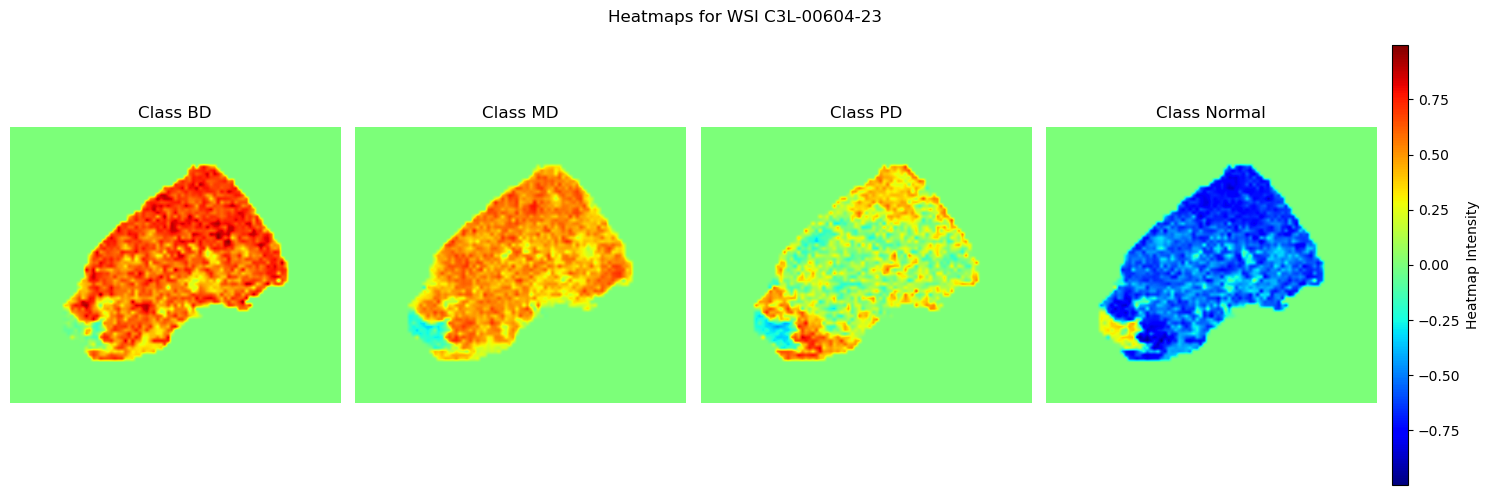

In [102]:
# Normalize all heatmaps to the same scale
vmin = np.min(heatmaps)
vmax = np.max(heatmaps)

# Create subplots with space for a colorbar
fig, axes = plt.subplots(1, 5, figsize=(15, 5), gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.05]})
fig.suptitle(f"Heatmaps for WSI {wsi_id}")

titles = ["Class BD", "Class MD", "Class PD", "Class Normal"]

heatmaps_list = [heatmaps[:, :, i] for i in range(heatmaps.shape[2])]

# Plot heatmaps
for ax, heatmap, title in zip(axes[:-1], heatmaps_list, titles):  # Exclude the last axis for the colorbar
    im = ax.imshow(heatmap.squeeze(), cmap="jet", vmin=vmin, vmax=vmax)  # Use the same vmin and vmax
    ax.set_title(title)
    ax.axis("off")

# Add a single colorbar in the last axis
cbar = fig.colorbar(im, cax=axes[-1], orientation="vertical")
cbar.set_label("Heatmap Intensity")

# Show the plot
plt.tight_layout()
plt.show()

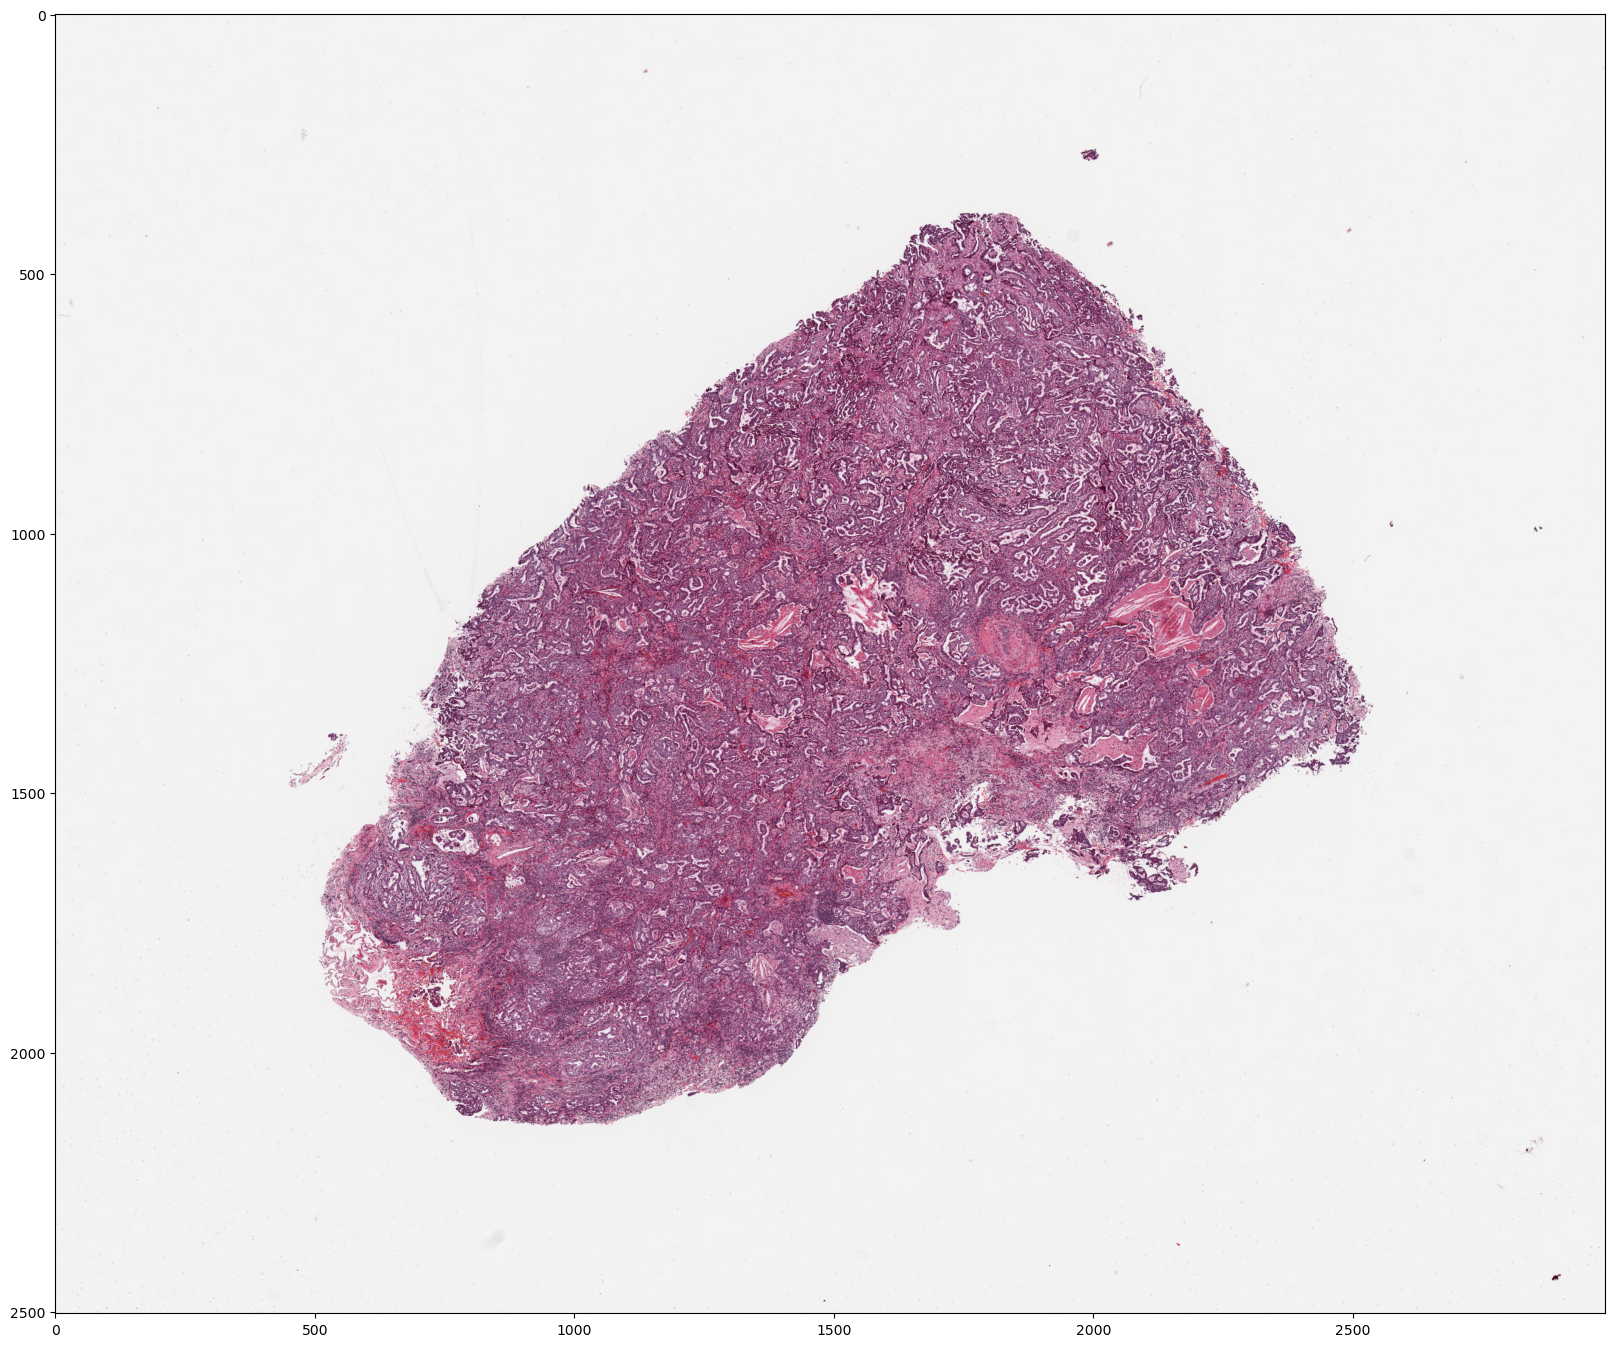

In [103]:
plt.figure(figsize=(20, 20))
plt.imshow(thumbnail)